# Unsupervised Learning / Clustering
#### BBC Full Text
#### Napassorn Litchiowong (diluxed@gmail.com)

In [10]:
%%capture
!pip install kagglehub pandas numpy matplotlib seaborn scikit-learn nltk wordcloud

import kagglehub
path = kagglehub.dataset_download("shivamkushwaha/bbc-full-text-document-classification")

In [11]:
print("Path to dataset files:", path)


Path to dataset files: /root/.cache/kagglehub/datasets/shivamkushwaha/bbc-full-text-document-classification/versions/1


In [12]:
import os
import glob
import pandas as pd

bbc_path = os.path.join(path, "bbc")

categories = ["business", "entertainment", "politics", "sport", "tech"]
data = []
labels = []

for cat in categories:
    folder = os.path.join(bbc_path, cat)
    # Find all .txt files in the subfolder
    for file in glob.glob(folder + "/*.txt"):
        with open(file, "r", encoding="utf-8", errors="ignore") as f:
            text = f.read()
        data.append(text)
        labels.append(cat)

df = pd.DataFrame({"text": data, "category": labels})
print("Number of documents:", df.shape[0])
print(df.head())


Number of documents: 2225
                                                text  category
0  GE sees 'excellent' world economy\n\nUS behemo...  business
1  Latin America sees strong growth\n\nLatin Amer...  business
2  Burren awarded Egyptian contracts\n\nBritish e...  business
3  US adds more jobs than expected\n\nThe US econ...  business
4  India calls for fair trade rules\n\nIndia, whi...  business


In [13]:
import glob

data = []
labels = []
for category in ["business","entertainment","politics","sport","tech"]:
    folder = os.path.join(path, "bbc", category)  # adjust to your structure
    for file in glob.glob(folder+"/*.txt"):
        with open(file, encoding="utf-8", errors="ignore") as f:
            text = f.read()
        data.append(text)
        labels.append(category)

df = pd.DataFrame({"text": data, "category": labels})
print(df.shape)
df.head()


(2225, 2)


,text,category
0,GE sees 'excellent' world economy\n\nUS behemo...,business
1,Latin America sees strong growth\n\nLatin Amer...,business
2,Burren awarded Egyptian contracts\n\nBritish e...,business
3,US adds more jobs than expected\n\nThe US econ...,business
4,"India calls for fair trade rules\n\nIndia, whi...",business


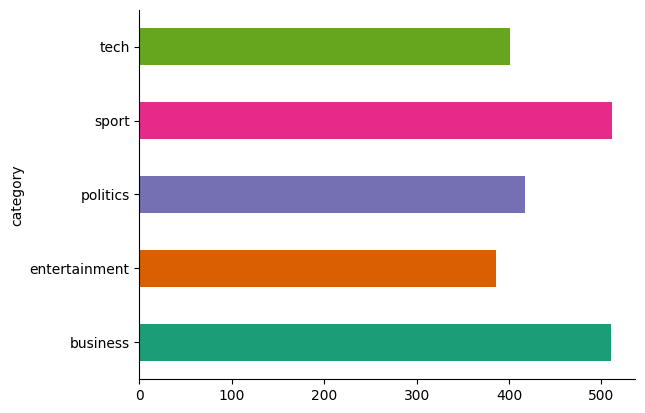

In [14]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('category').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [16]:
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("stopwords")

def clean_text(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    tokens = word_tokenize(text.lower())
    sw = stopwords.words("english")
    tokens = [t for t in tokens if t not in sw and t.isalpha()]
    return " ".join(tokens)

df["cleaned_text"] = df["text"].apply(clean_text)
df["text_length"] = df["cleaned_text"].apply(lambda x: len(x.split()))
df["category"].value_counts()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,count
category,
sport,511
business,510
politics,417
tech,401
entertainment,386


In [ ]:
from wordcloud import WordCloud

all_text = " ".join(df["cleaned_text"])

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_tfidf = tfidf.fit_transform(df["cleaned_text"])

print("TF-IDF shape:", X_tfidf.shape)


TF-IDF shape: (2225, 5000)


In [20]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=100, random_state=42)
X_reduced = svd.fit_transform(X_tfidf)


In [159]:
from sklearn.cluster import KMeans
k = 2
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
clusters = kmeans.fit_predict(X_reduced)
df["cluster"] = clusters


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


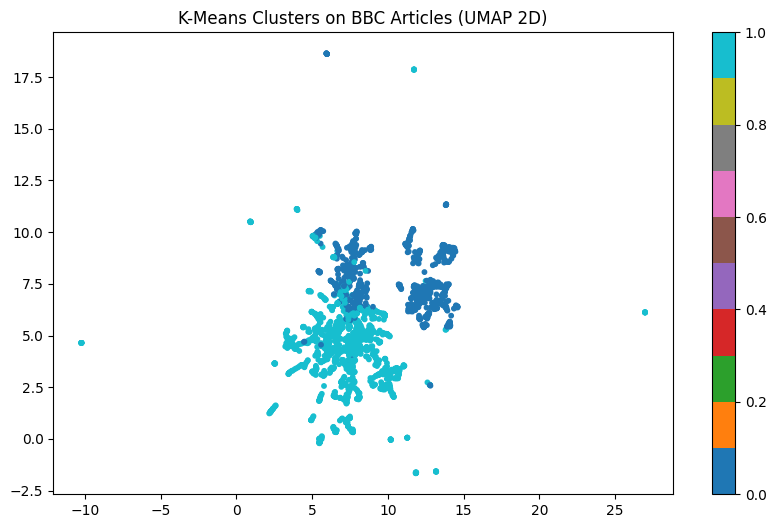

In [160]:
from sklearn.preprocessing import StandardScaler
import umap
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reduced)
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
umap_2d = reducer.fit_transform(X_scaled)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
scatter = plt.scatter(umap_2d[:,0], umap_2d[:,1], c=clusters, cmap="tab10", s=10)
plt.colorbar(scatter)
plt.title("K-Means Clusters on BBC Articles (UMAP 2D)")
plt.show()


In [161]:
def top_terms_per_cluster(X, clusters, tfidf_vectorizer, top_n=10):
    cluster_centroids = {}
    for c in np.unique(clusters):
        idx = np.where(clusters == c)
        mean_vec = X[idx].mean(axis=0)
        # Convert to array if sparse
        mean_vec = np.asarray(mean_vec).ravel()
        top_indices = mean_vec.argsort()[::-1][:top_n]
        top_words = [tfidf_vectorizer.get_feature_names_out()[i] for i in top_indices]
        cluster_centroids[c] = top_words
    return cluster_centroids

cluster_words = top_terms_per_cluster(X_tfidf, clusters, tfidf)
for c, words in cluster_words.items():
    print(f"Cluster {c}: {words}")


Cluster 0: ['film', 'said', 'best', 'game', 'first', 'win', 'world', 'last', 'play', 'england']
Cluster 1: ['said', 'mr', 'would', 'people', 'us', 'government', 'new', 'year', 'also', 'could']


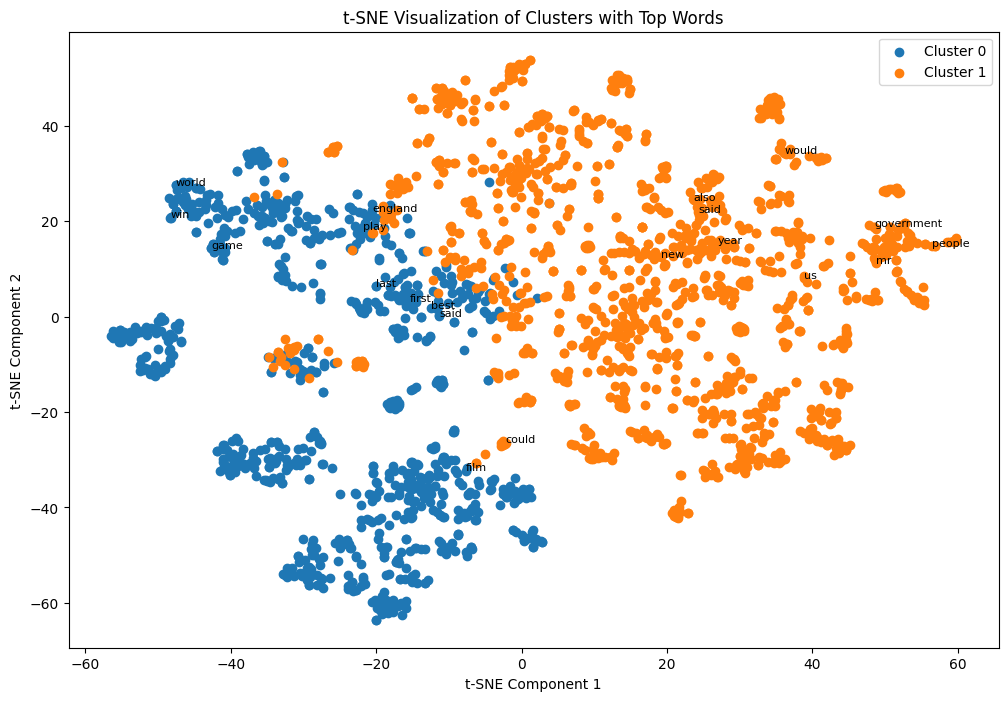

In [162]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
tsne_2d = tsne.fit_transform(X_reduced)

plt.figure(figsize=(12, 8))

for cluster_id, words in cluster_words.items():
    cluster_indices = np.where(clusters == cluster_id)[0]

    cluster_coords = tsne_2d[cluster_indices]

    plt.scatter(cluster_coords[:, 0], cluster_coords[:, 1], label=f'Cluster {cluster_id}')

    for i, word in enumerate(words[:15]):
        word_index_in_cluster = cluster_indices[i]
        plt.annotate(word, tsne_2d[word_index_in_cluster], fontsize=8)

plt.title("t-SNE Visualization of Clusters with Top Words")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.show()


In [163]:
from sklearn.metrics import silhouette_score
sil_score = silhouette_score(X_reduced, clusters)
print("Silhouette Score:", sil_score)


Silhouette Score: 0.035425545951362256


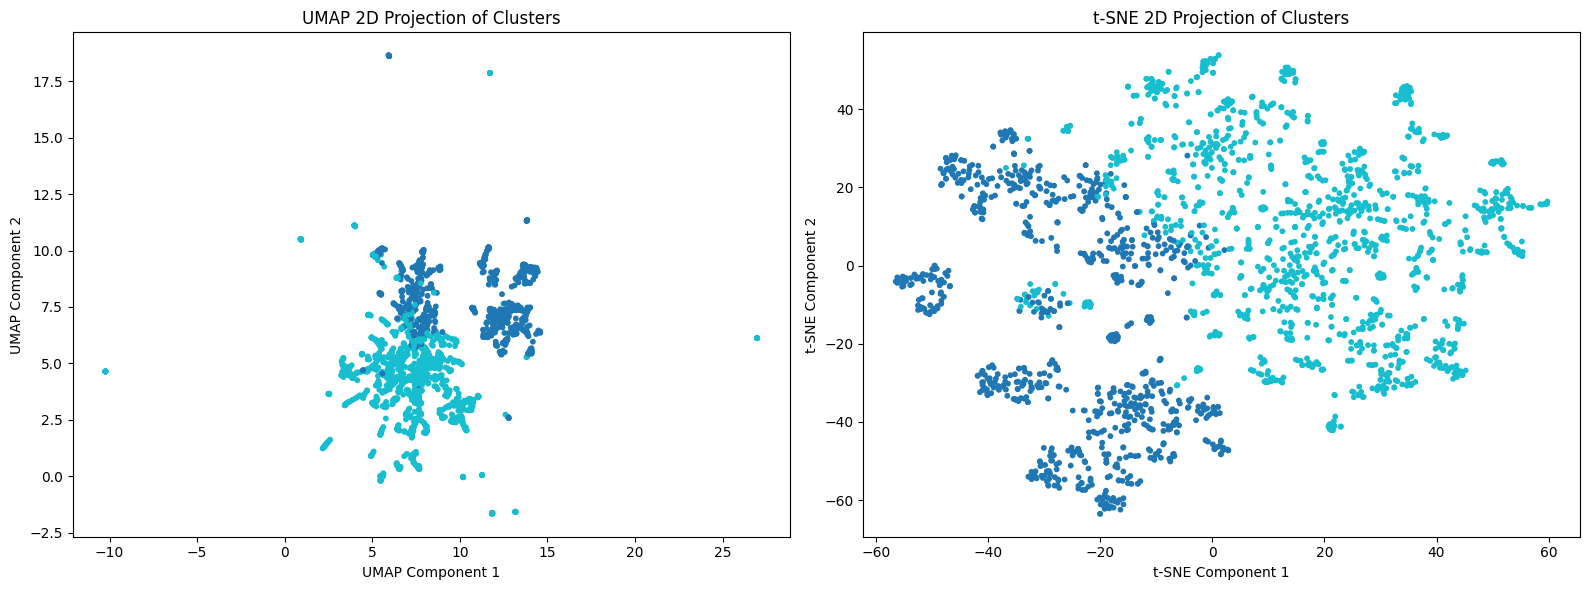

In [164]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].scatter(umap_2d[:, 0], umap_2d[:, 1], c=clusters, cmap="tab10", s=10)
axes[0].set_title("UMAP 2D Projection of Clusters")
axes[0].set_xlabel("UMAP Component 1")
axes[0].set_ylabel("UMAP Component 2")

tsne = TSNE(n_components=2, random_state=42)
tsne_2d = tsne.fit_transform(X_reduced)
axes[1].scatter(tsne_2d[:, 0], tsne_2d[:, 1], c=clusters, cmap="tab10", s=10)
axes[1].set_title("t-SNE 2D Projection of Clusters")
axes[1].set_xlabel("t-SNE Component 1")
axes[1].set_ylabel("t-SNE Component 2")

plt.tight_layout()
plt.savefig("combined_umap_tsne.png", dpi=150)
plt.show()


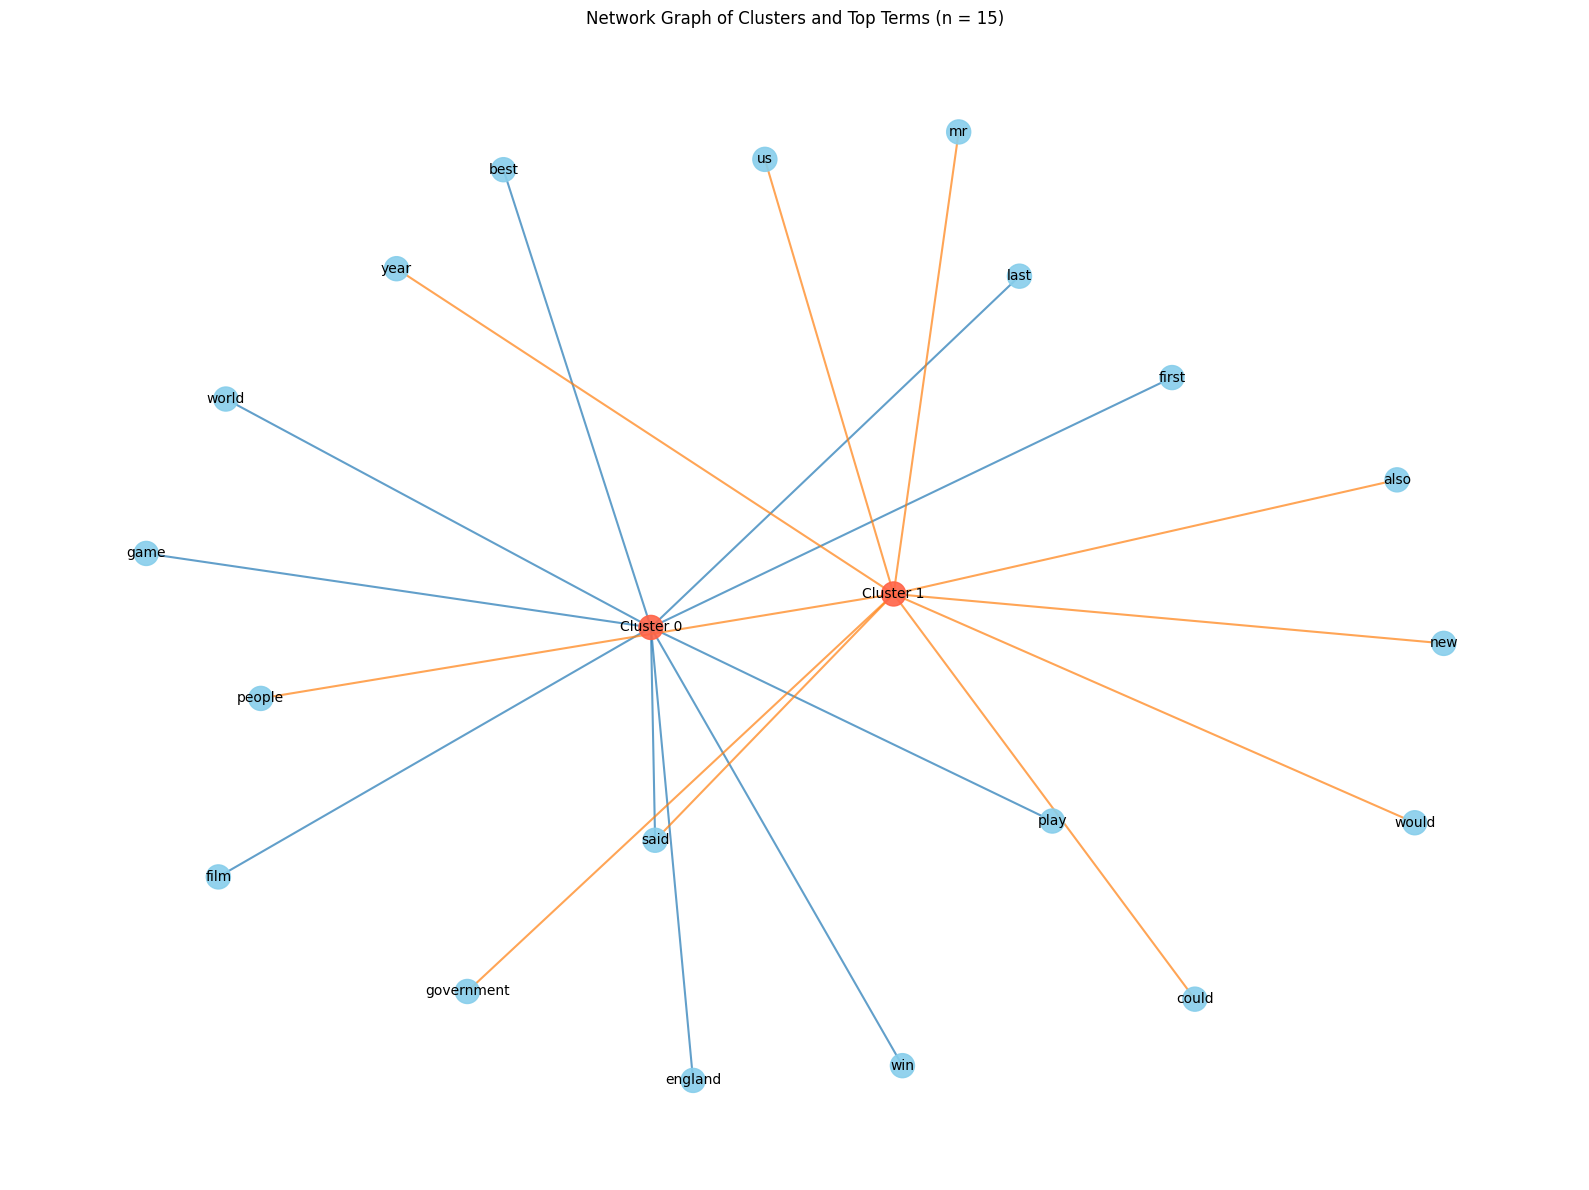

In [165]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm

G = nx.Graph()
for cluster_id, words in cluster_words.items():
    cluster_node = f"Cluster {cluster_id}"
    G.add_node(cluster_node, type="cluster")
    for word in words:
        G.add_node(word, type="word")
        G.add_edge(cluster_node, word)

pos = nx.spring_layout(G, k=1.2, scale=20)

cluster_nodes = [node for node, data in G.nodes(data=True) if data["type"]=="cluster"]
cmap = plt.get_cmap("tab10")
cluster_color_map = {cl: cmap(i % 10) for i, cl in enumerate(cluster_nodes)}
node_colors = ["tomato" if data["type"]=="cluster" else "skyblue" for node, data in G.nodes(data=True)]

edge_colors = []
for u, v in G.edges():
    if u.startswith("Cluster"):
        edge_colors.append(cluster_color_map[u])
    elif v.startswith("Cluster"):
        edge_colors.append(cluster_color_map[v])
    else:
        edge_colors.append("gray")

plt.figure(figsize=(16,12))
nx.draw_networkx_nodes(G, pos, node_size=300, node_color=node_colors, alpha=0.9)
nx.draw_networkx_edges(G, pos, width=1.5, edge_color=edge_colors, alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=10)
plt.title("Network Graph of Clusters and Top Terms (n = 15)")
plt.axis('off')
plt.tight_layout()
plt.savefig("network_graph_zoomed.png", dpi=150)
plt.show()


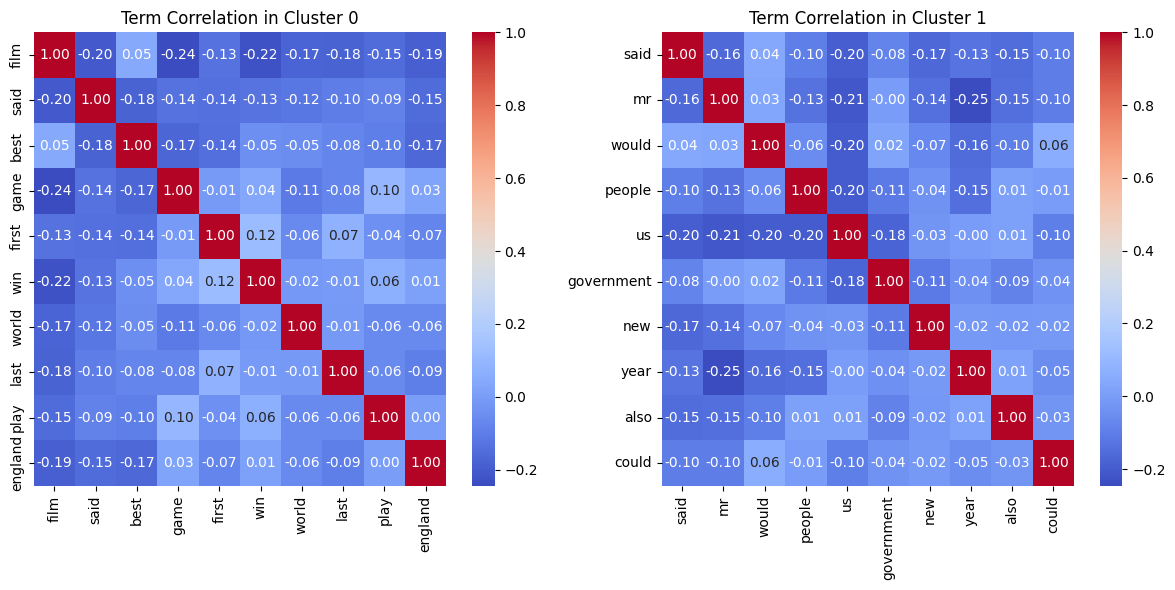

In [166]:
import math
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

cluster_ids = list(cluster_words.keys())
num_clusters = len(cluster_ids)
num_cols = 2
num_rows = math.ceil(num_clusters / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6 * num_rows))
axes = axes.flatten()

for i, cluster_num in enumerate(cluster_ids):
    terms = cluster_words[cluster_num]
    tfidf_cluster = TfidfVectorizer(vocabulary=terms)
    df_cluster = df[df["cluster"] == cluster_num]
    X_cluster_tfidf = tfidf_cluster.fit_transform(df_cluster["cleaned_text"])
    df_cluster_tfidf = pd.DataFrame(X_cluster_tfidf.toarray(), columns=tfidf_cluster.get_feature_names_out())
    corr_matrix = df_cluster_tfidf.corr()
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", ax=axes[i])
    axes[i].set_title(f"Term Correlation in Cluster {cluster_num}")

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


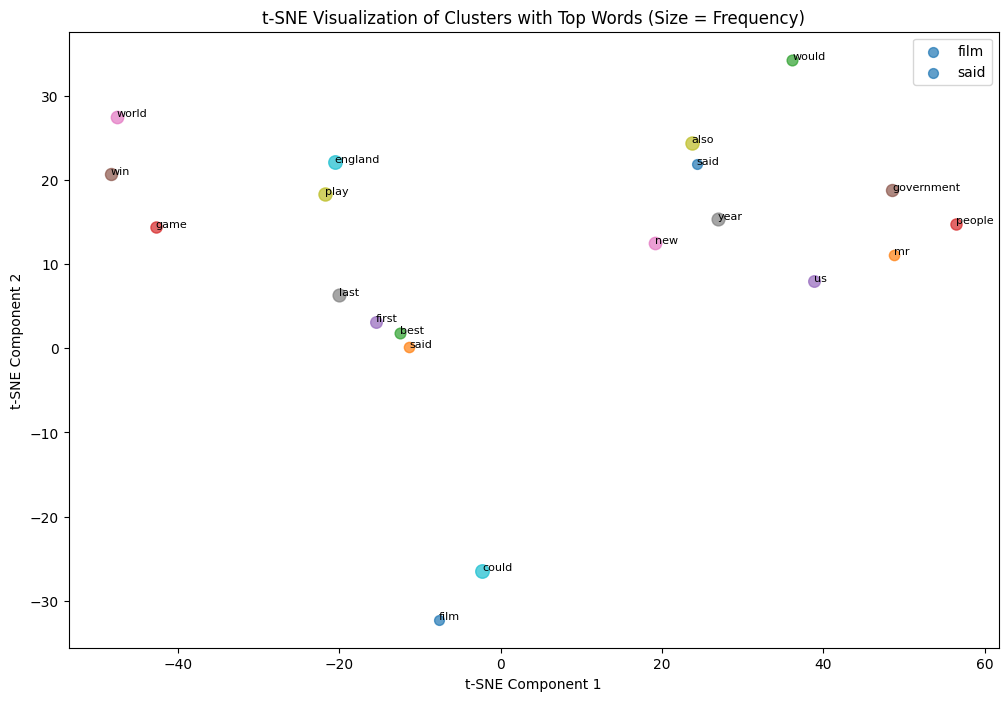

In [167]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

for cluster_id, words in cluster_words.items():
    cluster_indices = np.where(clusters == cluster_id)[0]
    cluster_coords = tsne_2d[cluster_indices]

    word_frequencies = {word: 10 + i for i, word in enumerate(words)}

    for i, word in enumerate(words[:15]):
        word_index_in_cluster = cluster_indices[i]
        plt.scatter(tsne_2d[word_index_in_cluster, 0], tsne_2d[word_index_in_cluster, 1],
                    s=word_frequencies[word] * 5,
                    label=word if i == 0 else "",
                    alpha=0.7)
        plt.annotate(word, tsne_2d[word_index_in_cluster], fontsize=8)

plt.title("t-SNE Visualization of Clusters with Top Words (Size = Frequency)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="best", markerscale=1)
plt.show()
